In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [2]:
nopts = pd.read_csv('big/noptsubs.txt', delimiter="|")
nopts['received_at'] = pd.to_datetime(nopts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
nopts['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in nopts['received_at'].values])

nopts.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring,slot_boundary
0,2023-03-13 17:57:45.774553,f,12410,1786,75578,6903,96678,0x978a35,2023-03-13 17:57:48
1,2023-03-13 17:57:45.698805,f,89843,1617,105741,6568,203771,0xa82f9a,2023-03-13 17:57:48
2,2023-03-13 17:57:45.810121,f,7900,1768,96445,7302,113417,0x84b02b,2023-03-13 17:57:48
3,2023-03-13 17:57:43.602490,f,90470,1353,98227,5276,195328,0xa1dead,2023-03-13 17:57:48
4,2023-03-13 17:57:43.675843,f,87590,1465,101181,5469,195707,0xa85807,2023-03-13 17:57:48


In [3]:
opts = pd.read_csv('big/optsubs.txt', delimiter="|")
opts['received_at'] = pd.to_datetime(opts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
opts['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in opts['received_at'].values])

opts.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring,slot_boundary
0,2023-03-17 12:12:33.673550,t,12062,1407,11,5999,19481,0xb33333,2023-03-17 12:12:36
1,2023-03-17 12:12:20.659166,t,101735,1449,7,5578,108770,0x83d349,2023-03-17 12:12:24
2,2023-03-17 12:12:20.822450,t,11241,2096,10,6061,19409,0x978a35,2023-03-17 12:12:24
3,2023-03-17 12:12:21.083129,t,135937,1408,10,8629,145986,0x83d349,2023-03-17 12:12:24
4,2023-03-17 12:12:22.254343,t,234029,1672,7,5794,241504,0x83d349,2023-03-17 12:12:24


In [4]:
len(nopts), len(opts)

(1000000, 912063)

In [5]:
np.percentile(opts['total_duration'].values, 99)

1153253.32

In [6]:
bdo = opts[opts['total_duration'] < np.percentile(opts['total_duration'].values, 99)]['total_duration'].values
bdn = nopts[nopts['total_duration'] < np.percentile(nopts['total_duration'].values, 99)]['total_duration'].values

In [7]:
len(bdn), len(bdo)

(990000, 902942)

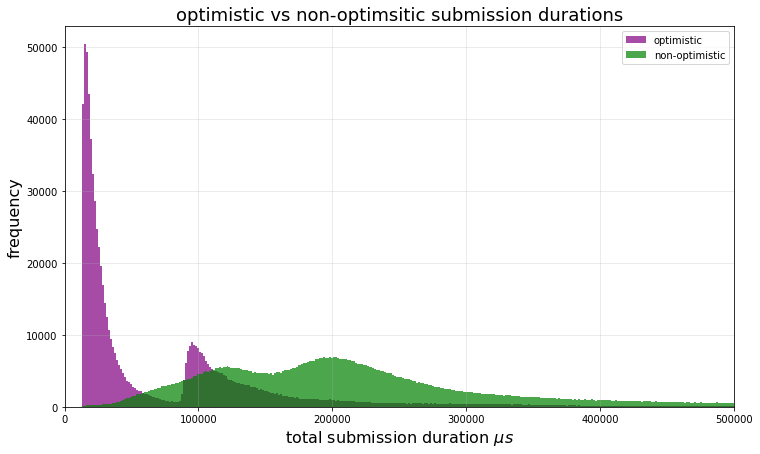

In [9]:
f, ax = plt.subplots(figsize=(12,7))

bins = np.histogram(bdn, bins=1000)[1]
ax.hist(bdo, bins, color='purple', alpha=0.7, density=False, label='optimistic')
ax.hist(bdn, bins, color='g', alpha=0.7, density=False, label='non-optimistic')
ax.set_xlim(0,float(0.5e6))
ax.set_xlabel('total submission duration $\mu s$', size=16)
ax.set_ylabel('frequency', size=16)
ax.set_title('optimistic vs non-optimsitic submission durations', size=18)
plt.legend()
plt.show()

In [58]:
pks = set(opts['substring'])

In [10]:
builders = pd.read_csv('big/builders.txt', delimiter="|")
builders.head()

,substring,is_optimistic,is_high_prio,collateral,builder_id,description
0,0xaec4ec,t,t,1000000000000000000,beaverbuild,beaver
1,0x96a59d,t,t,1000000000000000000,beaverbuild,beaver
2,0xb5d883,t,t,1000000000000000000,beaverbuild,beaver
3,0x8dde59,t,t,1000000000000000000,beaverbuild,beaver
4,0x8c344f,t,t,1000000000000000000,bob,bob


In [11]:
descriptions = builders[['substring', 'builder_id']].copy()
descriptions.head()

,substring,builder_id
0,0xaec4ec,beaverbuild
1,0x96a59d,beaverbuild
2,0xb5d883,beaverbuild
3,0x8dde59,beaverbuild
4,0x8c344f,bob


In [12]:
opts_builders = opts.merge(descriptions, on='substring', how='left')
opts_builders.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring,slot_boundary,builder_id
0,2023-03-17 12:12:33.673550,t,12062,1407,11,5999,19481,0xb33333,2023-03-17 12:12:36,smithbot
1,2023-03-17 12:12:20.659166,t,101735,1449,7,5578,108770,0x83d349,2023-03-17 12:12:24,rsync
2,2023-03-17 12:12:20.822450,t,11241,2096,10,6061,19409,0x978a35,2023-03-17 12:12:24,rsync
3,2023-03-17 12:12:21.083129,t,135937,1408,10,8629,145986,0x83d349,2023-03-17 12:12:24,rsync
4,2023-03-17 12:12:22.254343,t,234029,1672,7,5794,241504,0x83d349,2023-03-17 12:12:24,rsync


In [13]:
buids = set(opts_builders['builder_id'])
buids.remove('BuildAI')
buids

{'Titan',
 'beaverbuild',
 'bob',
 'builder0x69',
 'finest',
 'manta',
 'rsync',
 'smithbot'}

In [14]:
bdo = opts_builders[opts_builders['total_duration'] < np.percentile(opts_builders['total_duration'].values, 99)]

In [15]:
len(bdo[bdo['builder_id']=='builder0x69'])

240433

In [123]:
bins = np.histogram(bdo[bdo['builder_id']=='builder0x69']['total_duration'].values, bins=500)[1]

In [124]:
colors = plt.cm.copper(np.linspace(0, 1, 8))

0 0 builder0x69
240433
1 0 rsync
180995
2 0 finest
3424
3 0 beaverbuild
165737
0 1 manta
51876
1 1 Titan
57681
2 1 smithbot
41480
3 1 bob
160512


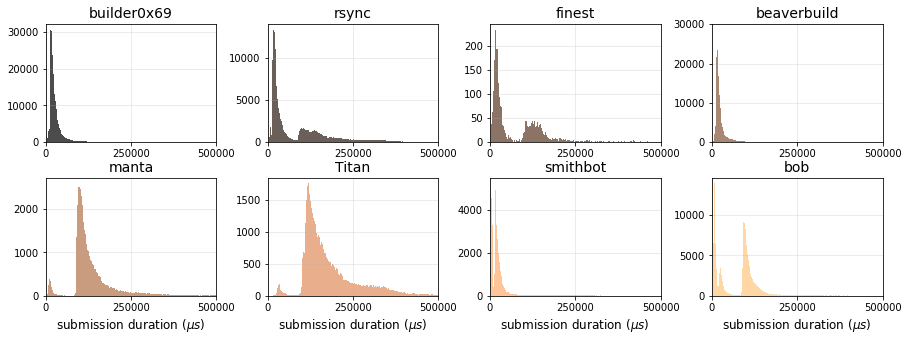

In [126]:
f, axarr = plt.subplots(nrows=2,ncols=4, figsize=(15,5))

for i, b in enumerate(buids):
    print(i % 4, i//4, b)
    r,c = i//4, i%4
    vals = bdo[bdo['builder_id']==b]['total_duration'].values
    print(len(vals))
    axarr[r,c].hist(
        vals,
        bins=bins,
        color=colors[i],
        alpha=0.7,
        density=False,
        label=b
    )
    if r == 1:
        axarr[r,c].set_xlabel('submission duration $(\mu s)$', size=12)
    axarr[r,c].set_xlim(0,float(0.5e6))
    axarr[r,c].set_title(b, size=14)
    axarr[r,c].set_xticks([0, 250000, 500000])
plt.subplots_adjust(hspace=.3)
plt.subplots_adjust(wspace=.3)
plt.show()


In [34]:
def printdf(df):
    print('decode\_duration & ', end='')
    st = ''
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['decode_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('prechecks\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['prechecks_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('simulation\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['simulation_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('redis\_update\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['redis_update_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('total\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['total_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')

In [116]:
printdf(nopts)

decode\_duration & 85020 & 101600 & 146920 & 304896 \\
prechecks\_duration & 1698 & 2207 & 7363 & 316881 \\
simulation\_duration & 113377 & 148299 & 218973 & 744570 \\
redis\_update\_duration & 6206 & 8859 & 31508 & 567347 \\
total\_duration & 204528 & 285357 & 464722 & 1486526 \\


In [117]:
printdf(opts_builders)

decode\_duration & 16566 & 91327 & 134511 & 326649 \\
prechecks\_duration & 1717 & 2317 & 4940 & 479328 \\
simulation\_duration & 8 & 10 & 12 & 28 \\
redis\_update\_duration & 6911 & 10756 & 25583 & 443122 \\
total\_duration & 30597 & 109495 & 191159 & 1153253 \\


In [36]:
winners = pd.read_csv('big/winningsubs.txt', delimiter="|")
winners['received_at'] = pd.to_datetime(nopts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
winners['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in winners['received_at'].values])
winners['diff'] = [v.total_seconds() for v in winners['slot_boundary'] - winners['received_at']]

winners.head()

,substring,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,slot,block_hash,slot_boundary,diff
0,0x8bc8d1,2023-03-13 17:57:45.774553,f,9581,1291,89316,5942,106133,5992187,0xf19358e829a0bd231a45e47fdf66a64573c75bb849c7...,2023-03-13 17:57:48,2.225447
1,0xb5d883,2023-03-13 17:57:45.698805,f,7618,1631,69939,5873,85062,5992228,0x9f7b42578928ea022cad8cfee2d5814182a456704470...,2023-03-13 17:57:48,2.301195
2,0x81babe,2023-03-13 17:57:45.810121,f,90865,3028,100385,6604,200883,5992188,0x9d4008e6922000d26a4c690de8a4ad989b916f408110...,2023-03-13 17:57:48,2.189879
3,0xb5d883,2023-03-13 17:57:43.602490,f,12264,1423,88255,19044,120988,5992190,0x6339f22bd451ed670644cfeff5502d9a8052520a2865...,2023-03-13 17:57:48,4.397510
4,0xb5d883,2023-03-13 17:57:43.675843,f,10573,2102,131210,8006,151892,5992191,0xf950dc49936dc56d9755a9f324389ec776bb2d303f19...,2023-03-13 17:57:48,4.324157


In [134]:
wo = winners[winners['optimistic_submission']=='t']
wn = winners[winners['optimistic_submission']=='f']

In [135]:
len(wo), len(wn)

(1029, 6875)

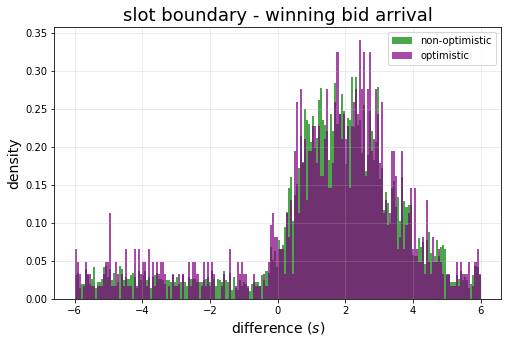

In [151]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(wn['diff'], bins=200)[1]
ax.hist(wn['diff'], bins, color='g', alpha=0.7, density=True, label='non-optimistic')
ax.hist(wo['diff'], bins, color='purple', alpha=0.7, density=True, label='optimistic')
# ax.set_xlim(0,float(1e6))
ax.set_xlabel('difference $(s)$', size=14)
ax.set_ylabel('density', size=14)
ax.set_title('slot boundary - winning bid arrival', size=18)
plt.legend()
plt.show()

In [16]:
opts_builders = opts.merge(descriptions, on='substring', how='left')
nopts_builders = nopts.merge(descriptions, on='substring', how='left')

In [17]:
bdo = opts_builders[opts_builders['total_duration'] < np.percentile(opts_builders['total_duration'].values, 99)]
bdn = nopts_builders[nopts_builders['total_duration'] < np.percentile(nopts_builders['total_duration'].values, 99)]

In [18]:
# rsync specifically
len(bdo[bdo['builder_id']=='rsync']), len(bdn[bdn['builder_id']=='rsync'])

(180995, 141899)

In [19]:
rsync_o = bdo[bdo['builder_id']=='rsync']
rsync_n = bdn[bdn['builder_id']=='rsync']

In [20]:
set(rsync_o.substring), set(rsync_n.substring)

({'0x83d349', '0x945fc5', '0x978a35'}, {'0x83d349', '0x945fc5', '0x978a35'})

In [21]:
for b in set(rsync_o.substring):
    vals_o = rsync_o[rsync_o['substring']==b]['total_duration'].values
    vals_n = rsync_n[rsync_n['substring']==b]['total_duration'].values
    print(b + "- optimistic submissions: " + str(len(vals_o)) + " - non-optimistic submissions: " + str(len(vals_n)))

0x978a35- optimistic submissions: 108945 - non-optimistic submissions: 79613
0x83d349- optimistic submissions: 52285 - non-optimistic submissions: 44626
0x945fc5- optimistic submissions: 19765 - non-optimistic submissions: 17660


In [22]:
bins = np.histogram(rsync_o[rsync_o['substring']=='0x83d349']['total_duration'].values, bins=500)[1]

201887.8677460157 339080.17185730464
42225.76240304741 177926.21853214927


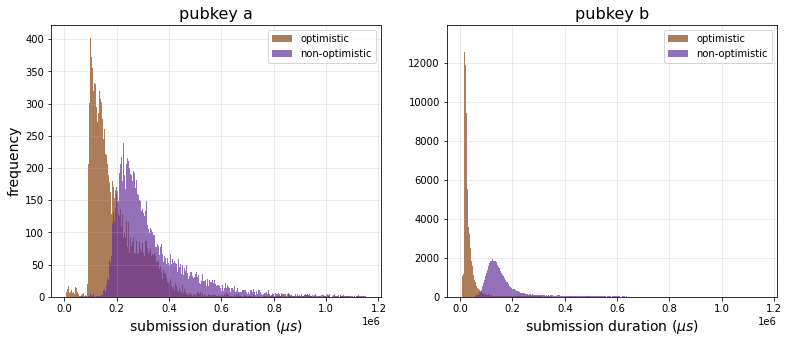

In [33]:
f, axarr = plt.subplots(nrows=1,ncols=2, figsize=(13,5))

for i, b in enumerate(['0x945fc5', '0x978a35']):
    vals_o = rsync_o[rsync_o['substring']==b]['total_duration'].values
    vals_n = rsync_n[rsync_n['substring']==b]['total_duration'].values
    print(vals_o.mean(), vals_n.mean())
    axarr[i].hist(
        vals_o,
        bins=bins,
        color='saddlebrown',
        alpha=0.7,
        density=False,
        label='optimistic'
    )
    axarr[i].hist(
        vals_n,
        bins=bins,
        color='rebeccapurple',
        alpha=0.7,
        density=False,
        label='non-optimistic'
    )
    axarr[i].legend()

    axarr[i].set_xlabel("submission duration $(\mu s)$", size=14)
axarr[0].set_ylabel("frequency", size=14)
axarr[0].set_title("pubkey a", size=16)
axarr[1].set_title("pubkey b", size=16)
plt.show()


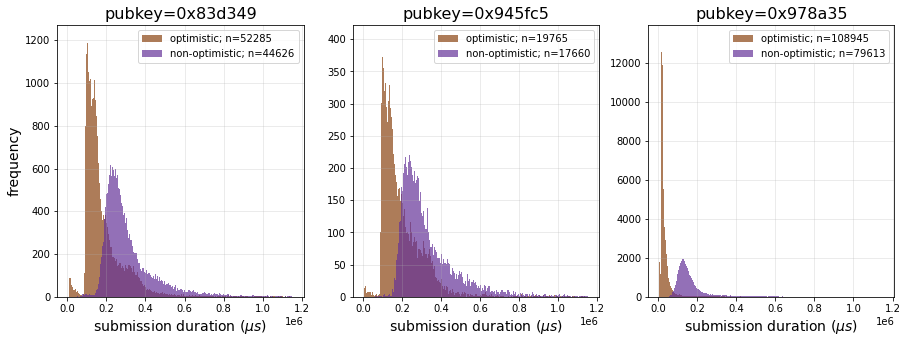

In [28]:
f, axarr = plt.subplots(nrows=1,ncols=3, figsize=(15,5))

for i, b in enumerate(['0x83d349', '0x945fc5', '0x978a35']):
    vals_o = rsync_o[rsync_o['substring']==b]['total_duration'].values
    vals_n = rsync_n[rsync_n['substring']==b]['total_duration'].values
    axarr[i].hist(
        vals_o,
        bins=bins,
        color='saddlebrown',
        alpha=0.7,
        density=False,
        label='optimistic; n={}'.format(len(vals_o))
    )
    axarr[i].hist(
        vals_n,
        bins=bins,
        color='rebeccapurple',
        alpha=0.7,
        density=False,
        label='non-optimistic; n={}'.format(len(vals_n))
    )
    axarr[i].legend()
    axarr[i].set_title("pubkey={}".format(b), size=16)
    axarr[i].set_xlabel("submission duration $(\mu s)$", size=14)
axarr[0].set_ylabel("frequency", size=14)
plt.show()


In [32]:
def printRow(df, colname, printname):
    print('{} & '.format(printname), end='')
    st = ''
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df[colname], i)))
        st += " & "
    print(st[:-3] + ' \\\\')

In [ ]:
for i, b in enumerate(['0x83d349', '0x945fc5', '0x978a35']):
    o = rsync_o[rsync_o['substring']==b]
    n = rsync_n[rsync_n['substring']==b]
    printRow(o, 'decode_duration', 'opt decode\_duration')
    printRow(n, 'decode_duration', 'nopt decode\_duration')
    print("\hline")
    printRow(o, 'prechecks_duration', 'opt prechecks\_duration')
    printRow(n, 'prechecks_duration', 'nopt prechecks\_duration')
    print("\hline")
    printRow(o, 'simulation_duration', 'opt simulation\_duration')
    printRow(n, 'simulation_duration', 'nopt simulation\_duration')
    print("\hline")
    printRow(o, 'redis_update_duration', 'opt redis\_update\_duration')
    printRow(n, 'redis_update_duration', 'nopt redis\_update\_duration')
    print("\hline")
    print("\hline")
    printRow(o, 'total_duration', 'opt total\_duration')
    printRow(n, 'total_duration', 'nopt total\_duration')
    print("\hline")
    
    
    
    print(b)
#     printdf(o)
#     printdf(n)

In [37]:
winners_builders = winners.merge(descriptions, on='substring', how='left')
winners_builders.head()

,substring,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,slot,block_hash,slot_boundary,diff,builder_id
0,0x8bc8d1,2023-03-13 17:57:45.774553,f,9581,1291,89316,5942,106133,5992187,0xf19358e829a0bd231a45e47fdf66a64573c75bb849c7...,2023-03-13 17:57:48,2.225447,NaN
1,0xb5d883,2023-03-13 17:57:45.698805,f,7618,1631,69939,5873,85062,5992228,0x9f7b42578928ea022cad8cfee2d5814182a456704470...,2023-03-13 17:57:48,2.301195,beaverbuild
2,0x81babe,2023-03-13 17:57:45.810121,f,90865,3028,100385,6604,200883,5992188,0x9d4008e6922000d26a4c690de8a4ad989b916f408110...,2023-03-13 17:57:48,2.189879,NaN
3,0xb5d883,2023-03-13 17:57:43.602490,f,12264,1423,88255,19044,120988,5992190,0x6339f22bd451ed670644cfeff5502d9a8052520a2865...,2023-03-13 17:57:48,4.397510,beaverbuild
4,0xb5d883,2023-03-13 17:57:43.675843,f,10573,2102,131210,8006,151892,5992191,0xf950dc49936dc56d9755a9f324389ec776bb2d303f19...,2023-03-13 17:57:48,4.324157,beaverbuild


In [48]:
w = winners_builders[winners_builders['total_duration'] < np.percentile(winners_builders['total_duration'].values, 99)]

In [49]:
# rsync specifically
len(w[w['builder_id']=='rsync'])

1118

In [51]:
rsync_w = w[w['builder_id']=='rsync']
rsync_o = rsync_w[rsync_w['optimistic_submission']=='t']
rsync_n = rsync_w[rsync_w['optimistic_submission']=='f']
len(rsync_o), len(rsync_n)

(178, 940)

In [64]:
rsync_n['diff'].mean(),rsync_o['diff'].var()

(1.4777672808510638, 4.730991315280895)

In [52]:
set(rsync_o.substring), set(rsync_n.substring)

({'0x83d349', '0x945fc5', '0x978a35'}, {'0x83d349', '0x945fc5', '0x978a35'})

In [30]:
def printRowFloat(df, colname, printname):
    print('{} & '.format(printname), end='')
    st = ''
    for i in [50, 75, 90, 99]:
        st += str(np.percentile(df[colname], i))
        st += " & "
    print(st[:-3] + ' \\\\')

In [57]:
for b in set(rsync_o.substring):
    vals_o = rsync_o[rsync_o['substring']==b]
    vals_n = rsync_n[rsync_n['substring']==b]
    printRowFloat(vals_o, 'diff', 'diff')
    printRowFloat(vals_n, 'diff', 'diff')
    print(b + "- optimistic submissions: " + str(len(vals_o)) + " - non-optimistic submissions: " + str(len(vals_n)))
    

diff & 2.053 & 3.15205475 & 3.9004609 & 5.255568759999999 \\
diff & 1.784135 & 2.9993024999999998 & 4.005310800000001 & 5.87933984 \\
0x978a35- optimistic submissions: 138 - non-optimistic submissions: 715
diff & 2.603325 & 3.2045315 & 3.8618388 & 4.23556038 \\
diff & 1.777883 & 2.6232805 & 3.1306578 & 3.8156700199999998 \\
0x945fc5- optimistic submissions: 7 - non-optimistic submissions: 27
diff & 2.454892 & 3.071774 & 3.6179276000000002 & 4.6877216399999995 \\
diff & 1.724374 & 2.7729645 & 3.8491559000000004 & 5.219483080000001 \\
0x83d349- optimistic submissions: 33 - non-optimistic submissions: 198


In [65]:
vals_o = rsync_o[rsync_o['substring']=='0x978a35']
vals_n = rsync_n[rsync_n['substring']=='0x978a35']
len(vals_o), len(vals_n)

(138, 715)

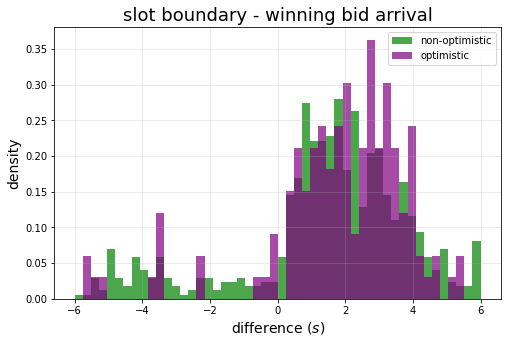

In [67]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(vals_n['diff'], bins=50)[1]
ax.hist(vals_n['diff'], bins, color='g', alpha=0.7, density=True, label='non-optimistic')
ax.hist(vals_o['diff'], bins, color='purple', alpha=0.7, density=True, label='optimistic')
# ax.set_xlim(0,float(1e6))
ax.set_xlabel('difference $(s)$', size=14)
ax.set_ylabel('density', size=14)
ax.set_title('slot boundary - winning bid arrival', size=18)
plt.legend()
plt.show()

In [9]:
opts_builders = opts.merge(descriptions, on='substring', how='left')
nopts_builders = nopts.merge(descriptions, on='substring', how='left')

In [10]:
bdo = opts_builders[opts_builders['total_duration'] < np.percentile(opts_builders['total_duration'].values, 99)]
bdn = nopts_builders[nopts_builders['total_duration'] < np.percentile(nopts_builders['total_duration'].values, 99)]

In [11]:
# rsync specifically
len(bdo[bdo['builder_id']=='builder0x69']), len(bdn[bdn['builder_id']=='builder0x69'])

(240433, 114160)

In [12]:
b69_o = bdo[bdo['builder_id']=='builder0x69']
b69_n = bdn[bdn['builder_id']=='builder0x69']

In [13]:
set(b69_o.substring), set(b69_n.substring)

({'0xa4fb63', '0xa971c4', '0xb194b2'}, {'0xa4fb63', '0xa971c4', '0xb194b2'})

In [14]:
for b in set(b69_o.substring):
    vals_o = b69_o[b69_o['substring']==b]['total_duration'].values
    vals_n = b69_n[b69_n['substring']==b]['total_duration'].values
    print(b + "- optimistic submissions: " + str(len(vals_o)) + " - non-optimistic submissions: " + str(len(vals_n)))

0xa4fb63- optimistic submissions: 83790 - non-optimistic submissions: 50918
0xa971c4- optimistic submissions: 64273 - non-optimistic submissions: 39125
0xb194b2- optimistic submissions: 92370 - non-optimistic submissions: 24117


In [21]:
bins = np.histogram(b69_o[b69_o['substring']=='0xa4fb63']['total_duration'].values, bins=500)[1]

AttributeError: module 'matplotlib.pyplot' has no attribute 's'

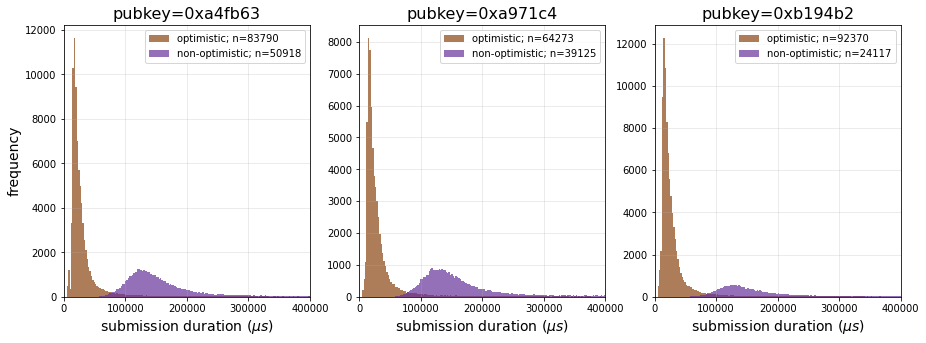

In [28]:
f, axarr = plt.subplots(nrows=1,ncols=3, figsize=(15,5))

for i, b in enumerate(['0xa4fb63', '0xa971c4', '0xb194b2']):
    vals_o = b69_o[b69_o['substring']==b]['total_duration'].values
    vals_n = b69_n[b69_n['substring']==b]['total_duration'].values
    axarr[i].hist(
        vals_o,
        bins=bins,
        color='saddlebrown',
        alpha=0.7,
        density=False,
        label='optimistic; n={}'.format(len(vals_o))
    )
    axarr[i].hist(
        vals_n,
        bins=bins,
        color='rebeccapurple',
        alpha=0.7,
        density=False,
        label='non-optimistic; n={}'.format(len(vals_n))
    )
    axarr[i].legend()
    axarr[i].set_title("pubkey={}".format(b), size=16)
    axarr[i].set_xlabel("submission duration $(\mu s)$", size=14)
    axarr[i].set_xlim(0,float(0.4e6))
    axarr[i].set_xticks([0, int(1e5), int(2e5), int(3e5), int(4e5)])
axarr[0].set_ylabel("frequency", size=14)
plt.show()

In [34]:
printRow(b69_o, 'total_duration', 'opt total\_duration')
printRow(b69_n, 'total_duration', 'non-opt total\_duration')

opt total\_duration & 22242 & 33337 & 62791 & 538920 \\
non-opt total\_duration & 146754 & 193392 & 319290 & 798933 \\


In [38]:
w = winners_builders

In [39]:
# rsync specifically
len(w[w['builder_id']=='builder0x69'])

1760

In [41]:
b6_w = w[w['builder_id']=='builder0x69']
b6_o = b6_w[b6_w['optimistic_submission']=='t']
b6_n = b6_w[b6_w['optimistic_submission']=='f']
len(b6_o), len(b6_n)

(372, 1388)

In [44]:
b6_o['diff'].mean(),b6_n['diff'].mean()

(1.315574258064516, 1.4672644747838617)

In [45]:
set(b6_o.substring), set(b6_n.substring)

({'0xa4fb63', '0xa971c4', '0xb194b2'}, {'0xa4fb63', '0xa971c4', '0xb194b2'})

In [46]:
def printRowFloat(df, colname, printname):
    print('{} & '.format(printname), end='')
    st = ''
    for i in [50, 75, 90, 99]:
        st += str(np.percentile(df[colname], i))
        st += " & "
    print(st[:-3] + ' \\\\')

In [47]:
for b in set(b6_o.substring):
    vals_o = b6_o[b6_o['substring']==b]
    vals_n = b6_n[b6_n['substring']==b]
    printRowFloat(vals_o, 'diff', 'diff')
    printRowFloat(vals_n, 'diff', 'diff')
    print(b + "- optimistic submissions: " + str(len(vals_o)) + " - non-optimistic submissions: " + str(len(vals_n)))
    

diff & 1.5769385 & 2.7717349999999996 & 3.6261997 & 5.4597417 \\
diff & 1.708495 & 2.849221 & 3.9373518 & 5.47265374 \\
0xa4fb63- optimistic submissions: 104 - non-optimistic submissions: 715
diff & 2.1424425 & 3.2718930000000004 & 4.0007011 & 5.36099103 \\
diff & 1.8233395 & 2.7437345000000004 & 3.8088831999999995 & 5.3265338 \\
0xa971c4- optimistic submissions: 62 - non-optimistic submissions: 394
diff & 2.0262325 & 3.0090152499999996 & 4.2665635 & 5.818006999999999 \\
diff & 1.571709 & 2.7714515000000004 & 3.833510000000001 & 5.602034859999991 \\
0xb194b2- optimistic submissions: 206 - non-optimistic submissions: 279


In [48]:
printRowFloat(b6_o, 'diff', 'opt diff')
printRowFloat(b6_n, 'diff', 'nopt diff')

opt diff & 1.9302709999999998 & 3.0546249999999997 & 4.077335900000002 & 5.726438600000003 \\
nopt diff & 1.7389139999999998 & 2.77739825 & 3.8898919 & 5.503619629999998 \\


In [49]:
opts_builders = opts.merge(descriptions, on='substring', how='left')
opts_builders.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring,slot_boundary,builder_id
0,2023-03-17 12:12:33.673550,t,12062,1407,11,5999,19481,0xb33333,2023-03-17 12:12:36,smithbot
1,2023-03-17 12:12:20.659166,t,101735,1449,7,5578,108770,0x83d349,2023-03-17 12:12:24,rsync
2,2023-03-17 12:12:20.822450,t,11241,2096,10,6061,19409,0x978a35,2023-03-17 12:12:24,rsync
3,2023-03-17 12:12:21.083129,t,135937,1408,10,8629,145986,0x83d349,2023-03-17 12:12:24,rsync
4,2023-03-17 12:12:22.254343,t,234029,1672,7,5794,241504,0x83d349,2023-03-17 12:12:24,rsync


In [50]:
nopts_builders = nopts.merge(descriptions, on='substring', how='left')
nopts_builders.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring,slot_boundary,builder_id
0,2023-03-13 17:57:45.774553,f,12410,1786,75578,6903,96678,0x978a35,2023-03-13 17:57:48,rsync
1,2023-03-13 17:57:45.698805,f,89843,1617,105741,6568,203771,0xa82f9a,2023-03-13 17:57:48,NaN
2,2023-03-13 17:57:45.810121,f,7900,1768,96445,7302,113417,0x84b02b,2023-03-13 17:57:48,NaN
3,2023-03-13 17:57:43.602490,f,90470,1353,98227,5276,195328,0xa1dead,2023-03-13 17:57:48,NaN
4,2023-03-13 17:57:43.675843,f,87590,1465,101181,5469,195707,0xa85807,2023-03-13 17:57:48,NaN


In [77]:
buids = set(descriptions['builder_id'])
buids.remove('Titan')
buids.remove('rickastley')
buids.remove('smithbot')
buids

{'BuildAI', 'beaverbuild', 'bob', 'builder0x69', 'finest', 'manta', 'rsync'}

In [78]:
pkMap = {}
for b in buids:
    pkMap[b] = descriptions[descriptions['builder_id']==b]['substring'].values

In [79]:
pkMap

{'builder0x69': array(['0xa4fb63', '0xb194b2', '0xa971c4'], dtype=object),
 'beaverbuild': array(['0xaec4ec', '0x96a59d', '0xb5d883', '0x8dde59'], dtype=object),
 'bob': array(['0x8c344f', '0x8d6e6c', '0xa31892', '0x91afe2', '0x987ff8'],
       dtype=object),
 'finest': array(['0x984357'], dtype=object),
 'manta': array(['0xb1b734', '0xa0d0db', '0xb5a688'], dtype=object),
 'rsync': array(['0x978a35', '0x945fc5', '0x83d349'], dtype=object),
 'BuildAI': array(['0x82ba7c'], dtype=object)}

In [94]:
for k in pkMap:
    vs = pkMap[k]
#     print(k)
    print("\\multirow{{{}}}{{*}}{{{}}}".format(len(vs),k))
    for v in vs:
        opts_mean = opts_builders[opts_builders['substring']==v]['total_duration'].values.mean()
        nopt_mean = nopts_builders[nopts_builders['substring']==v]['total_duration'].values.mean()
        print("& \\texttt{{{}}} & {} & {} & {:0.3f} \\\\".format(v,int(nopt_mean),int(opts_mean),nopt_mean/opts_mean))
    print("\\hline")
        

\multirow{3}{*}{builder0x69}
& \texttt{0xa4fb63} & 201046 & 60055 & 3.348 \\
& \texttt{0xb194b2} & 209878 & 58176 & 3.608 \\
& \texttt{0xa971c4} & 209154 & 62613 & 3.340 \\
\hline
\multirow{4}{*}{beaverbuild}
& \texttt{0xaec4ec} & 211693 & 65415 & 3.236 \\
& \texttt{0x96a59d} & 215846 & 61802 & 3.493 \\
& \texttt{0xb5d883} & 216438 & 62436 & 3.467 \\
& \texttt{0x8dde59} & 197262 & 61691 & 3.198 \\
\hline
\multirow{5}{*}{bob}
& \texttt{0x8c344f} & 235667 & 58777 & 4.009 \\
& \texttt{0x8d6e6c} & 357966 & 144760 & 2.473 \\
& \texttt{0xa31892} & 236578 & 57214 & 4.135 \\
& \texttt{0x91afe2} & 397859 & 159900 & 2.488 \\
& \texttt{0x987ff8} & 355329 & 142946 & 2.486 \\
\hline
\multirow{1}{*}{finest}
& \texttt{0x984357} & 394545 & 122656 & 3.217 \\
\hline
\multirow{3}{*}{manta}
& \texttt{0xb1b734} & 312012 & 159892 & 1.951 \\
& \texttt{0xa0d0db} & 313213 & 165333 & 1.894 \\
& \texttt{0xb5a688} & 309250 & 161053 & 1.920 \\
\hline
\multirow{3}{*}{rsync}
& \texttt{0x978a35} & 189193 & 54275 & 3.

In [6]:
# decode durations specifically

In [8]:
np.percentile(opts['decode_duration'].values, 99)

326649.0

In [9]:
bdo = opts[opts['decode_duration'] < np.percentile(opts['decode_duration'].values, 99)]['decode_duration'].values
bdn = nopts[nopts['decode_duration'] < np.percentile(nopts['decode_duration'].values, 99)]['decode_duration'].values

In [10]:
len(bdn), len(bdo)

(989999, 902941)

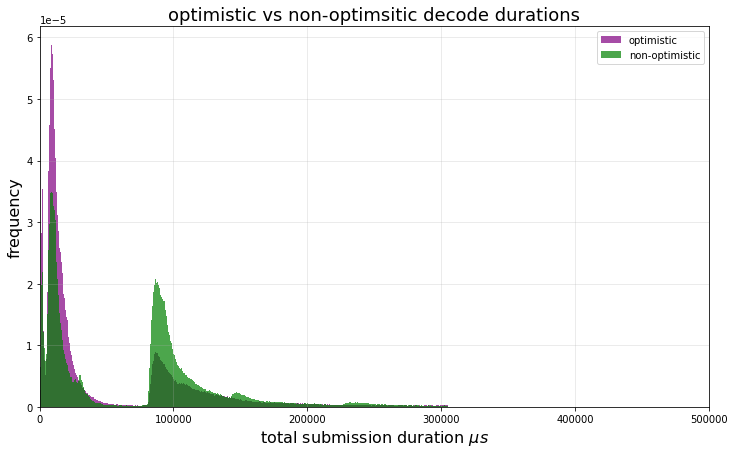

In [13]:
f, ax = plt.subplots(figsize=(12,7))

bins = np.histogram(bdn, bins=1000)[1]
ax.hist(bdo, bins, color='purple', alpha=0.7, density=True, label='optimistic')
ax.hist(bdn, bins, color='g', alpha=0.7, density=True, label='non-optimistic')
ax.set_xlim(0,float(0.5e6))
ax.set_xlabel('total submission duration $\mu s$', size=16)
ax.set_ylabel('frequency', size=16)
ax.set_title('optimistic vs non-optimsitic decode durations', size=18)
plt.legend()
plt.show()

In [14]:
pks = set(opts['substring'])

In [15]:
builders = pd.read_csv('big/builders.txt', delimiter="|")
builders.head()

,substring,is_optimistic,is_high_prio,collateral,builder_id,description
0,0xaec4ec,t,t,1000000000000000000,beaverbuild,beaver
1,0x96a59d,t,t,1000000000000000000,beaverbuild,beaver
2,0xb5d883,t,t,1000000000000000000,beaverbuild,beaver
3,0x8dde59,t,t,1000000000000000000,beaverbuild,beaver
4,0x8c344f,t,t,1000000000000000000,bob,bob


In [16]:
descriptions = builders[['substring', 'builder_id']].copy()
descriptions.head()

,substring,builder_id
0,0xaec4ec,beaverbuild
1,0x96a59d,beaverbuild
2,0xb5d883,beaverbuild
3,0x8dde59,beaverbuild
4,0x8c344f,bob


In [17]:
opts_builders = opts.merge(descriptions, on='substring', how='left')
opts_builders.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring,slot_boundary,builder_id
0,2023-03-17 12:12:33.673550,t,12062,1407,11,5999,19481,0xb33333,2023-03-17 12:12:36,smithbot
1,2023-03-17 12:12:20.659166,t,101735,1449,7,5578,108770,0x83d349,2023-03-17 12:12:24,rsync
2,2023-03-17 12:12:20.822450,t,11241,2096,10,6061,19409,0x978a35,2023-03-17 12:12:24,rsync
3,2023-03-17 12:12:21.083129,t,135937,1408,10,8629,145986,0x83d349,2023-03-17 12:12:24,rsync
4,2023-03-17 12:12:22.254343,t,234029,1672,7,5794,241504,0x83d349,2023-03-17 12:12:24,rsync


In [18]:
buids = set(opts_builders['builder_id'])
buids.remove('BuildAI')
buids

{'Titan',
 'beaverbuild',
 'bob',
 'builder0x69',
 'finest',
 'manta',
 'rsync',
 'smithbot'}

In [21]:
bdo = opts_builders[opts_builders['decode_duration'] < np.percentile(opts_builders['decode_duration'].values, 99)]

In [22]:
len(bdo[bdo['builder_id']=='builder0x69'])

242036

In [24]:
bins = np.histogram(bdo[bdo['builder_id']=='builder0x69']['decode_duration'].values, bins=500)[1]

In [25]:
colors = plt.cm.copper(np.linspace(0, 1, 8))

0 0 bob
161982
1 0 builder0x69
242036
2 0 finest
3480
3 0 beaverbuild
167112
0 1 manta
51640
1 1 rsync
178475
2 1 smithbot
41718
3 1 Titan
55741


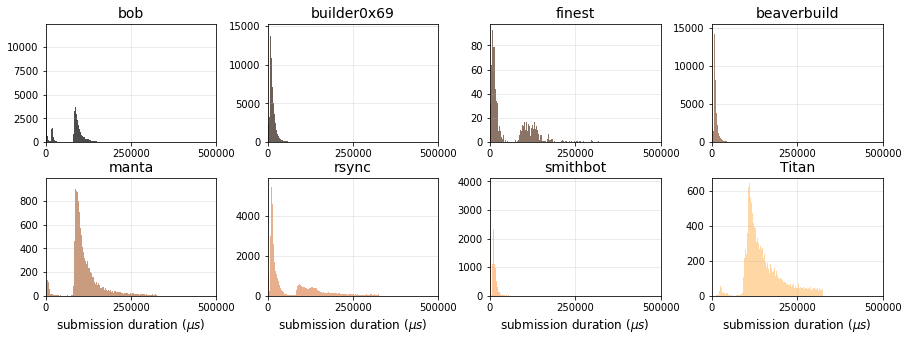

In [26]:
f, axarr = plt.subplots(nrows=2,ncols=4, figsize=(15,5))

for i, b in enumerate(buids):
    print(i % 4, i//4, b)
    r,c = i//4, i%4
    vals = bdo[bdo['builder_id']==b]['decode_duration'].values
    print(len(vals))
    axarr[r,c].hist(
        vals,
        bins=bins,
        color=colors[i],
        alpha=0.7,
        density=False,
        label=b
    )
    if r == 1:
        axarr[r,c].set_xlabel('submission duration $(\mu s)$', size=12)
    axarr[r,c].set_xlim(0,float(0.5e6))
    axarr[r,c].set_title(b, size=14)
    axarr[r,c].set_xticks([0, 250000, 500000])
plt.subplots_adjust(hspace=.3)
plt.subplots_adjust(wspace=.3)
plt.show()
